As an example, this notebook shows how to store 2D images in larcv data formats using `image2d` data product. How to store other form of data (2D/3D sparse data, clusters, etc.) would be a simple extension once you learn about this.

In [1]:
from __future__ import print_function
import ROOT
import numpy
from ROOT import larcv
larcv.load_pyutil()
import matplotlib.pyplot as plt
from scipy.ndimage import imread

Welcome to JupyROOT 6.08/06


## Getting an image sample
Need an image to convert.  Since I'm writing the tutorial, I get to use my daughter :)

In [2]:
_file = '/home/cadams/Desktop/norasaurus.jpg'
nora = imread(_file)
print(type(nora))

<type 'numpy.ndarray'>


Nora's type should actually be 'baby' but OK.

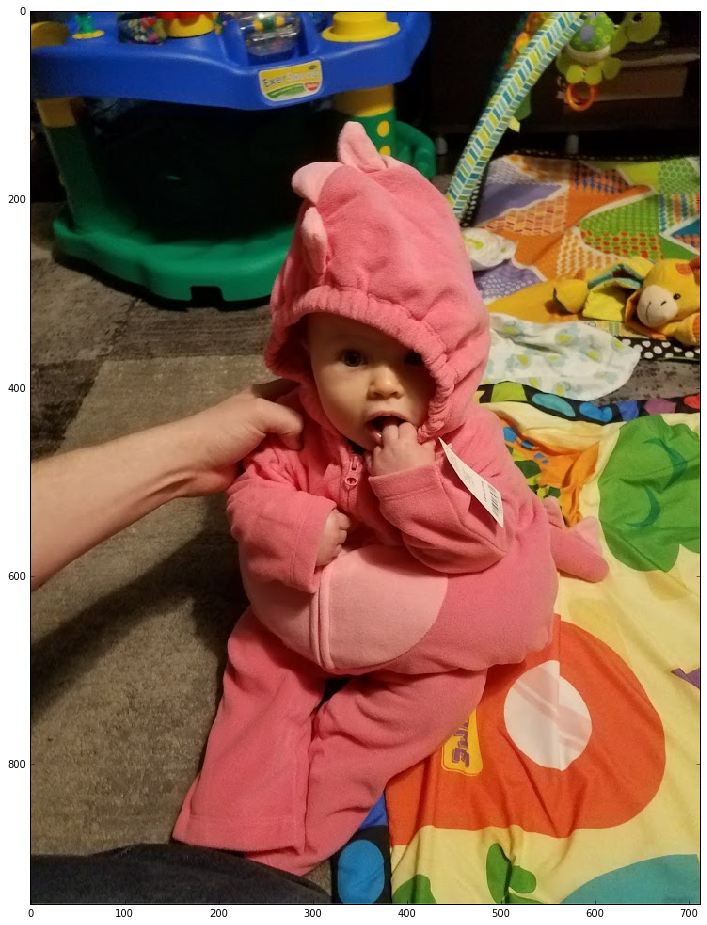

In [3]:
fig = plt.figure(figsize=(16,16))
plt.imshow(nora, interpolation='none')
plt.show()

Nora says: Happy Halloween!

## Using larcv file IO
Let's write her to a larcv image file.  Create an io manager to store this image:

In [4]:
io = larcv.IOManager(larcv.IOManager.kWRITE)

Above, we created an instance of io manager.  Below, we tell it where to store the output file (since we specified write mode)

In [5]:
io.set_out_file('imread.root')

And, we initialize the io manager:

In [6]:
io.initialize()

True

## Creating a 2D image data product
We need to request image2d data products to store the output.  If we request a product that doesn't exist in the file, it's created:

In [7]:
image2d_array = io.get_data('image2d', 'imread')

    [NORMAL]  <IOManager::get_data> Created TTree image2d_imread_tree (id=0) w/ 0 entries...


## Filling the data product
larcv specifically has a conversion from numpy array to `image2d` in a single function call, but here we will try doing it 'by hand' because it's more instructive (if slower).

In [8]:
print(nora.shape)

(949, 712, 3)


Nora has 3 channels (RGB), so we can split it into 3 images and store it in one event.  We need to make an image meta for each image too

In [10]:
for channel in xrange(3):
    _channel_slice = nora[:,:,channel].T
    n_x = _channel_slice.shape[0]
    n_y = _channel_slice.shape[1]
    meta = larcv.ImageMeta(0, 0, n_x, n_y, n_y, n_x, channel)
    # Need to copy the numpy array to std::vector:
    data = ROOT.std.vector('float')()
    data.reserve(n_x*n_y)
    for x in range(n_x):
        for y in range(n_y):
            # This gymnastics flips the image vertically:
            data.push_back(_channel_slice[x, n_y - (y+1)])
    _image2d = larcv.Image2D(meta, data)
    image2d_array.append(_image2d)

In [11]:
print(image2d_array.image2d_array().size())

3


## Write & close the file
Looks like we successfully appended 3 images to the file, write the file and close it:

In [12]:
io.set_id(0,0,0)

In [13]:
io.save_entry()

True

In [14]:
io.finalize()

    [NORMAL]  <IOManager::finalize> Writing image2d_imread_tree with 1 entries
    [NORMAL]  <IOManager::finalize> Closing output file


All of that is great.  You can now teach your network about Nora! As a next step, maybe try opening the file with a [larcv-viewer](https://github.com/DeepLearnPhysics/larcv-viewer). 